In [6]:
#!pip install --upgrade gym

In [7]:
import os
import gc
import torch
import pygame
import warnings
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Used for debugging; CUDA related errors shown immediately.

# Seed everything for reproducible results
seed = 2024
np.random.seed(seed)
np.random.default_rng(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class ReplayMemory:
    def __init__(self, capacity):
        """
        Experience Replay Memory defined by deques to store transitions/agent experiences
        """

        self.capacity = capacity

        self.states       = deque(maxlen=capacity)
        self.actions      = deque(maxlen=capacity)
        self.next_states  = deque(maxlen=capacity)
        self.rewards      = deque(maxlen=capacity)
        self.dones        = deque(maxlen=capacity)


    def store(self, state, action, next_state, reward, done):
        """
        Append (store) the transitions to their respective deques
        """

        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)


    def sample(self, batch_size):
        """
        Randomly sample transitions from memory, then convert sampled transitions
        to tensors and move to device (CPU or GPU).
        """

        indices = np.random.choice(len(self), size=batch_size, replace=False)

        states = torch.stack([torch.as_tensor(self.states[i], dtype=torch.float32, device=device) for i in indices]).to(device)
        actions = torch.as_tensor([self.actions[i] for i in indices], dtype=torch.long, device=device)
        next_states = torch.stack([torch.as_tensor(self.next_states[i], dtype=torch.float32, device=device) for i in indices]).to(device)
        rewards = torch.as_tensor([self.rewards[i] for i in indices], dtype=torch.float32, device=device)
        dones = torch.as_tensor([self.dones[i] for i in indices], dtype=torch.bool, device=device)

        return states, actions, next_states, rewards, dones


    def __len__(self):
        """
        To check how many samples are stored in the memory. self.dones deque
        represents the length of the entire memory.
        """

        return len(self.dones)


class DQN_Network(nn.Module):
    """
    The Deep Q-Network (DQN) model for reinforcement learning.
    This network consists of Fully Connected (FC) layers with ReLU activation functions.
    """

    def __init__(self, num_actions, input_dim):
        """
        Initialize the DQN network.

        Parameters:
            num_actions (int): The number of possible actions in the environment.
            input_dim (int): The dimensionality of the input state space.
        """

        super(DQN_Network, self).__init__()

        self.FC = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, num_actions)
            )

        # Initialize FC layer weights using He initialization
        for layer in [self.FC]:
            for module in layer:
                if isinstance(module, nn.Linear):
                    nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')


    def forward(self, x):
        """
        Forward pass of the network to find the Q-values of the actions.

        Parameters:
            x (torch.Tensor): Input tensor representing the state.

        Returns:
            Q (torch.Tensor): Tensor containing Q-values for each action.
        """

        Q = self.FC(x)
        return Q


class DQN_Agent:
    """
    DQN Agent Class. This class defines some key elements of the DQN algorithm,
    such as the learning method, hard update, and action selection based on the
    Q-value of actions or the epsilon-greedy policy.
    """

    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay,
                  clip_grad_norm, learning_rate, discount, memory_capacity):

        # To save the history of network loss
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

        # RL hyperparameters
        self.epsilon_max   = epsilon_max
        self.epsilon_min   = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount      = discount

        self.action_space  = env.action_space
        self.action_space.seed(seed) # Set the seed to get reproducible results when sampling the action space
        self.observation_space = env.observation_space
        self.replay_memory = ReplayMemory(memory_capacity)

        # Initiate the network models
        input_dim = self.observation_space.shape[0]
        output_dim = self.action_space.n

        self.main_network = DQN_Network(num_actions=output_dim, input_dim=input_dim).to(device)
        self.target_network = DQN_Network(num_actions=output_dim, input_dim=input_dim).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

        self.clip_grad_norm = clip_grad_norm # For clipping exploding gradients caused by high reward value
        self.critertion = nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)


    def select_action(self, state):
        """
        Selects an action using epsilon-greedy strategy OR based on the Q-values.

        Parameters:
            state (torch.Tensor): Input tensor representing the state.

        Returns:
            action (int): The selected action.
        """

        # Exploration: epsilon-greedy
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # Exploitation: the action is selected based on the Q-values.
        # Check if the state is a tensor or not. If not, make it a tensor
        if not torch.is_tensor(state):
            state = torch.as_tensor(state, dtype=torch.float32, device=device)

        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()

            return action


    def learn(self, batch_size, done):
        """
        Train the main network using a batch of experiences sampled from the replay memory.

        Parameters:
            batch_size (int): The number of experiences to sample from the replay memory.
            done (bool): Indicates whether the episode is done or not. If done,
            calculate the loss of the episode and append it in a list for plot.
        """

        # Sample a batch of experiences from the replay memory
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)


        # # The following prints are for debugging. Use them to indicate the correct shape of the tensors.
        # print('Before--------Before')
        # print("states:", states.shape)
        # print("actions:", actions.shape)
        # print("next_states:", next_states.shape)
        # print("rewards:", rewards.shape)
        # print("dones:", dones.shape)


        # # Preprocess the data for training
        # states        = states.unsqueeze(1)
        # next_states   = next_states.unsqueeze(1)
        actions       = actions.unsqueeze(1)
        rewards       = rewards.unsqueeze(1)
        dones         = dones.unsqueeze(1)


        # # The following prints are for debugging. Use them to indicate the correct shape of the tensors.
        # print()
        # print('After--------After')
        # print("states:", states.shape)
        # print("actions:", actions.shape)
        # print("next_states:", next_states.shape)
        # print("rewards:", rewards.shape)
        # print("dones:", dones.shape)


        predicted_q = self.main_network(states) # forward pass through the main network to find the Q-values of the states
        predicted_q = predicted_q.gather(dim=1, index=actions) # selecting the Q-values of the actions that were actually taken

        # Compute the maximum Q-value for the next states using the target network
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0] # not argmax (cause we want the maxmimum q-value, not the action that maximize it)


        next_target_q_value[dones] = 0 # Set the Q-value for terminal states to zero
        y_js = rewards + (self.discount * next_target_q_value) # Compute the target Q-values
        loss = self.critertion(predicted_q, y_js) # Compute the loss

        # Update the running loss and learned counts for logging and plotting
        self.running_loss += loss.item()
        self.learned_counts += 1

        if done:
            episode_loss = self.running_loss / self.learned_counts # The average loss for the episode
            self.loss_history.append(episode_loss) # Append the episode loss to the loss history for plotting
            # Reset the running loss and learned counts
            self.running_loss = 0
            self.learned_counts = 0

        self.optimizer.zero_grad() # Zero the gradients
        loss.backward() # Perform backward pass and update the gradients

        # # Uncomment the following two lines to find the best value for clipping gradient (Comment torch.nn.utils.clip_grad_norm_ while uncommenting the following two lines)
        # grad_norm_before_clip = torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), float('inf'))
        # print("Gradient norm before clipping:", grad_norm_before_clip)

        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)

        self.optimizer.step() # Update the parameters of the main network using the optimizer


    def hard_update(self):
        """
        Navie update: Update the target network parameters by directly copying
        the parameters from the main network.
        """

        self.target_network.load_state_dict(self.main_network.state_dict())


    def update_epsilon(self):
        """
        Update the value of epsilon for epsilon-greedy exploration.

        This method decreases epsilon over time according to a decay factor, ensuring
        that the agent becomes less exploratory and more exploitative as training progresses.
        """

        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)


    def save(self, path):
        """
        Save the parameters of the main network to a file with .pth extention.

        """
        torch.save(self.main_network.state_dict(), path)


class step_wrapper(gym.Wrapper):
    """
    A wrapper class for modifying the state and reward functions of the
    MountainCar-v0 environment.
    """

    def __init__(self, env):
        """
        Initializes the StepWrapper. This is the main class for wrapping the environment with it.

        Args:
            env (gym.Env): The environment to be wrapped.

        Attributes:
            observation_wrapper (Inherit from ObservationWrapper):
                An instance of the ObservationWrapper class for modifying observations.
            reward_wrapper (Inherit from RewardWrapper):
                An instance of the RewardWrapper class for modifying rewards.
        """
        super().__init__(env) # We give the env here to initialize the gym.Wrapper superclass (inherited).

        self.observation_wrapper = observation_wrapper(env)
        self.reward_wrapper = reward_wrapper(env)


    def step(self, action):
        """
        Executes a step in the environment with the provided action.The reason
        behind using this method is to have access to the state and reward functions return.

        Args:
            action (int): The action to be taken.
        """

        state, reward, done, truncation, info = self.env.step(action) # Same as before as usual

        modified_state = self.observation_wrapper.observation(state) # Give the state to another Wrapper, which returns a modified version of state
        modified_reward = self.reward_wrapper.reward(modified_state) # Give the modified state to another Wrapper to return the modified reward

        return modified_state, modified_reward, done, truncation, info # The same returns as usual but with modified versions of the state and reward functions


    def reset(self, seed):
        state, info = self.env.reset(seed=seed) # Same as before as usual
        modified_state = self.observation_wrapper.observation(state) # Give the state to another Wrapper, which returns a modified version of state

        return modified_state, info # Same as before as usual but with returning the modified version of the state


class observation_wrapper(gym.ObservationWrapper):
    """
    Wrapper class for modifying observations in the MountainCar-v0 environment.

    Args:
        env (gym.Env): The environment to wrap.

    Attributes:
        min_value (numpy.ndarray): Array of minimum observation values (2 dimensions because of the state.).
        max_value (numpy.ndarray): Array of maximum observation values (2 dimensions because of the state.).
    """

    def __init__(self, env):
        super().__init__(env)

        self.min_value = env.observation_space.low
        self.max_value = env.observation_space.high


    def observation(self, state):
        """
        Modifies the observation by clipping the values and normalizing it.

        Args:
            state (numpy.ndarray): The original observation from the environment.

        Returns:
            numpy.ndarray: The modified and normalized observation.
        """

        normalized_state = (state - self.min_value) / (self.max_value - self.min_value) # Min-max normalization

        return normalized_state


class reward_wrapper(gym.RewardWrapper):
    """
    Wrapper class for modifying rewards in the MountainCar-v0 environment.

    Args:
        env (gym.Env): The environment to wrap.
    """

    def __init__(self, env):
        super().__init__(env)


    def reward(self, state):
        """
        Modifies the reward based on the current state of the environment.

        Args:
            state (numpy.ndarray): The current state of the environment.

        Returns:
            float: The modified reward.
        """

        current_position, current_velocity = state # extract the position and current velocity based on the state

        # Interpolate the value to the desired range (because the velocity normalized value would be in range of 0 to 1 and now it would be in range of -0.5 to 0.5)
        current_velocity = np.interp(current_velocity, np.array([0, 1]), np.array([-0.5, 0.5]))

        # (1) Calculate the modified reward based on the current position and velocity of the car.
        degree = current_position * 360
        degree2radian = np.deg2rad(degree)
        modified_reward =  0.2 * (np.cos(degree2radian) + 2 * np.abs(current_velocity))

        # (2) Step limitation
        modified_reward -= 0.5 # Subtract 0.5 to adjust the base reward (to limit useless steps).

        # (3) Check if the car has surpassed a threshold of the path and is closer to the goal
        if current_position > 0.98:
            modified_reward += 20  # Add a bonus reward (Reached the goal)
        elif current_position > 0.92:
            modified_reward += 10 # So close to the goal
        elif current_position > 0.82:
            modified_reward += 6 # car is closer to the goal
        elif current_position > 0.65:
            modified_reward += 1 - np.exp(-2 * current_position) # car is getting close. Thus, giving reward based on the position and the further it reached


        # (4) Check if the car is coming down with velocity from left and goes with full velocity to right
        initial_position = 0.40842572 # Normalized value of initial position of the car which is extracted manually

        if current_velocity > 0.3 and current_position > initial_position + 0.1:
            modified_reward += 1 + 2 * current_position  # Add a bonus reward for this desired behavior

        return modified_reward



In [9]:

class Model_TrainTest():
    def __init__(self, hyperparams):

        # Define RL Hyperparameters
        self.train_mode             = hyperparams["train_mode"]
        self.RL_load_path           = hyperparams["RL_load_path"]
        self.save_path              = hyperparams["save_path"]
        self.save_interval          = hyperparams["save_interval"]

        self.clip_grad_norm         = hyperparams["clip_grad_norm"]
        self.learning_rate          = hyperparams["learning_rate"]
        self.discount_factor        = hyperparams["discount_factor"]
        self.batch_size             = hyperparams["batch_size"]
        self.update_frequency       = hyperparams["update_frequency"]
        self.max_episodes           = hyperparams["max_episodes"]
        self.max_steps              = hyperparams["max_steps"]
        self.render                 = hyperparams["render"]

        self.epsilon_max            = hyperparams["epsilon_max"]
        self.epsilon_min            = hyperparams["epsilon_min"]
        self.epsilon_decay          = hyperparams["epsilon_decay"]

        self.memory_capacity        = hyperparams["memory_capacity"]

        self.render_fps             = hyperparams["render_fps"]

        # Define Env
        self.env = gym.make('MountainCar-v0', max_episode_steps=self.max_steps,
                            render_mode="rgb_array_list" if self.render else None)
        self.env.metadata['render_fps'] = self.render_fps # For max frame rate make it 0

        """
        The 'MountainCar-v0' environment in the 'gymnasium' library generates
        UserWarnings about deprecated methods.
        These warnings are related to the 'size' and 'shape' methods which are
        being phased out in a future version of the library.
        Even though we are not directly using these methods in our code, the
        warnings are still displayed.
        To keep our output clean and focused on our own program's execution,
        the following line of code is for ignoring these warnings.
        """
        warnings.filterwarnings("ignore", category=UserWarning)

        # Apply RewardWrapper
        self.env = step_wrapper(self.env)

        # Define the agent class
        self.agent = DQN_Agent(env               = self.env,
                               epsilon_max       = self.epsilon_max,
                               epsilon_min       = self.epsilon_min,
                               epsilon_decay     = self.epsilon_decay,
                               clip_grad_norm    = self.clip_grad_norm,
                               learning_rate     = self.learning_rate,
                               discount          = self.discount_factor,
                               memory_capacity   = self.memory_capacity)


    def train(self):
        """
        Reinforcement learning training loop.
        """

        total_steps = 0
        self.reward_history = []

        # Training loop over episodes
        for episode in range(1, self.max_episodes+1):
            state, _ = self.env.reset(seed=seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)

                self.agent.replay_memory.store(state, action, next_state, reward, done)

                if len(self.agent.replay_memory) > self.batch_size:
                    self.agent.learn(self.batch_size, (done or truncation))

                    # Update target-network weights
                    if total_steps % self.update_frequency == 0:
                        self.agent.hard_update()

                state = next_state
                episode_reward += reward
                step_size +=1

            # Appends for tracking history
            self.reward_history.append(episode_reward) # episode reward
            total_steps += step_size

            # Decay epsilon at the end of each episode
            self.agent.update_epsilon()

            #-- based on interval
            if episode % self.save_interval == 0:
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                if episode != self.max_episodes:
                    self.plot_training(episode)
                print('\n~~~~~~Interval Save: Model saved.\n')

            result = (f"Episode: {episode}, "
                      f"Total Steps: {total_steps}, "
                      f"Ep Step: {step_size}, "
                      f"Raw Reward: {episode_reward:.2f}, "
                      f"Epsilon: {self.agent.epsilon_max:.2f}")
            print(result)
        self.plot_training(episode)


    def test(self, max_episodes):
        """
        Reinforcement learning policy evaluation.
        """

        # Load the weights of the test_network
        self.agent.main_network.load_state_dict(torch.load(self.RL_load_path))
        self.agent.main_network.eval()
        history = []
        rewards=[]
        steps=[]
        failed =0
        # Testing loop over episodes
        for episode in range(1, max_episodes+1):
            frames = []
            state, _ = self.env.reset(seed=seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0
            temp_history= []
            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)

                state = next_state
                episode_reward += reward
                step_size += 1
                temp_history.append({'state':state,'action':action})
                frames.append(self.env.render())
            if step_size<200:
                history = history + temp_history
            if step_size>499:
                failed +=1
            # Print log
            steps.append(step_size)
            rewards.append(episode_reward)
            result = (f"Episode: {episode}, "
                      f"Steps: {step_size:}, "
                      f"Reward: {episode_reward:.2f}, ")
            print(result)

        pygame.quit() # close the rendering window
        return history,frames,steps,rewards,failed

    def plot_training(self, episode):
        # Calculate the Simple Moving Average (SMA) with a window size of 50
        sma = np.convolve(self.reward_history, np.ones(50)/50, mode='valid')

        # Clip max (high) values for better plot analysis
        reward_history = np.clip(self.reward_history, a_min=None, a_max=100)
        sma = np.clip(sma, a_min=None, a_max=100)

        plt.figure()
        plt.title("Obtained Rewards")
        plt.plot(reward_history, label='Raw Reward', color='#4BA754', alpha=1)
        plt.plot(sma, label='SMA 50', color='#F08100')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()

        # Only save as file if last episode
        if episode == self.max_episodes:
            plt.savefig('./reward_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()


        plt.figure()
        plt.title("Network Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#8921BB', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")

        # Only save as file if last episode
        if episode == self.max_episodes:
            plt.savefig('./Loss_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()


Episode: 1, Total Steps: 500, Ep Step: 500, Raw Reward: -303.85, Epsilon: 1.00
Episode: 2, Total Steps: 1000, Ep Step: 500, Raw Reward: -294.35, Epsilon: 0.99
Episode: 3, Total Steps: 1500, Ep Step: 500, Raw Reward: -314.98, Epsilon: 0.99
Episode: 4, Total Steps: 2000, Ep Step: 500, Raw Reward: -284.38, Epsilon: 0.99
Episode: 5, Total Steps: 2500, Ep Step: 500, Raw Reward: -314.81, Epsilon: 0.98
Episode: 6, Total Steps: 3000, Ep Step: 500, Raw Reward: -307.78, Epsilon: 0.98
Episode: 7, Total Steps: 3500, Ep Step: 500, Raw Reward: -304.71, Epsilon: 0.98
Episode: 8, Total Steps: 4000, Ep Step: 500, Raw Reward: -301.16, Epsilon: 0.98
Episode: 9, Total Steps: 4500, Ep Step: 500, Raw Reward: -314.22, Epsilon: 0.97
Episode: 10, Total Steps: 5000, Ep Step: 500, Raw Reward: -309.49, Epsilon: 0.97
Episode: 11, Total Steps: 5500, Ep Step: 500, Raw Reward: -305.82, Epsilon: 0.97
Episode: 12, Total Steps: 6000, Ep Step: 500, Raw Reward: -299.91, Epsilon: 0.96
Episode: 13, Total Steps: 6500, Ep Ste

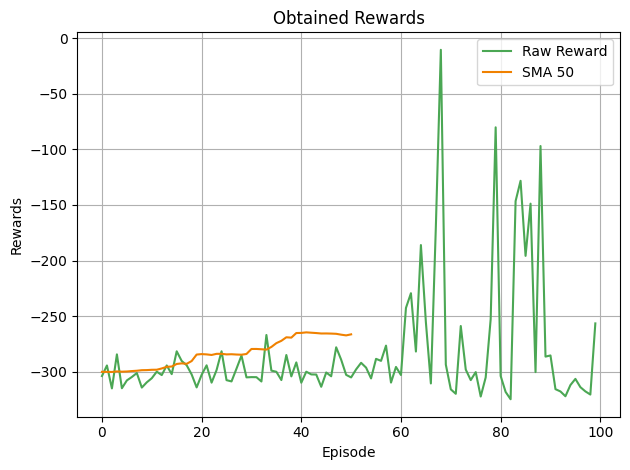

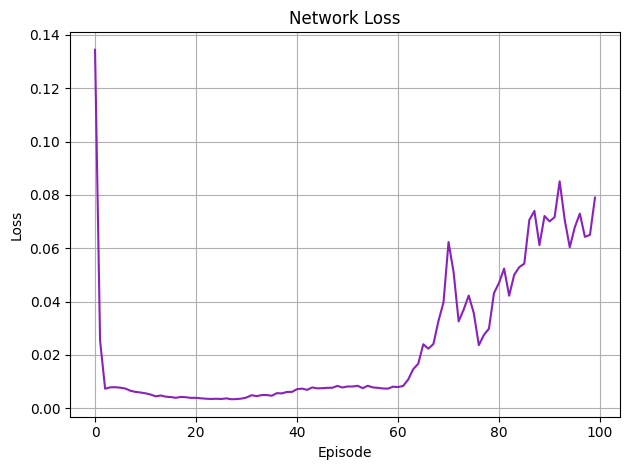


~~~~~~Interval Save: Model saved.

Episode: 100, Total Steps: 49807, Ep Step: 500, Raw Reward: -256.52, Epsilon: 0.74
Episode: 101, Total Steps: 50307, Ep Step: 500, Raw Reward: -299.15, Epsilon: 0.74
Episode: 102, Total Steps: 50807, Ep Step: 500, Raw Reward: -318.29, Epsilon: 0.74
Episode: 103, Total Steps: 51307, Ep Step: 500, Raw Reward: -318.44, Epsilon: 0.73
Episode: 104, Total Steps: 51807, Ep Step: 500, Raw Reward: -86.52, Epsilon: 0.73
Episode: 105, Total Steps: 52307, Ep Step: 500, Raw Reward: -320.95, Epsilon: 0.73
Episode: 106, Total Steps: 52807, Ep Step: 500, Raw Reward: -326.14, Epsilon: 0.73
Episode: 107, Total Steps: 53307, Ep Step: 500, Raw Reward: -307.20, Epsilon: 0.72
Episode: 108, Total Steps: 53807, Ep Step: 500, Raw Reward: -321.75, Epsilon: 0.72
Episode: 109, Total Steps: 54307, Ep Step: 500, Raw Reward: -324.76, Epsilon: 0.72
Episode: 110, Total Steps: 54807, Ep Step: 500, Raw Reward: -300.33, Epsilon: 0.72
Episode: 111, Total Steps: 55307, Ep Step: 500, Raw 

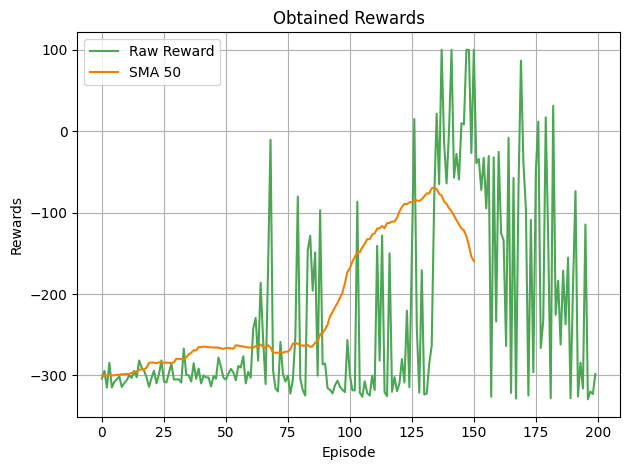

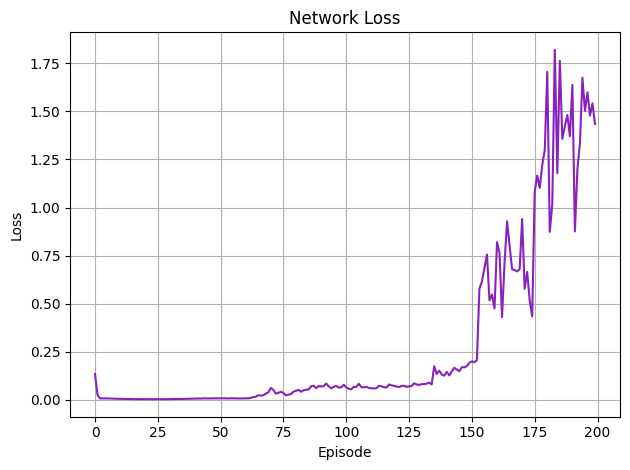


~~~~~~Interval Save: Model saved.

Episode: 200, Total Steps: 93921, Ep Step: 500, Raw Reward: -298.31, Epsilon: 0.55
Episode: 201, Total Steps: 94207, Ep Step: 286, Raw Reward: -38.87, Epsilon: 0.55
Episode: 202, Total Steps: 94707, Ep Step: 500, Raw Reward: -102.65, Epsilon: 0.54
Episode: 203, Total Steps: 95207, Ep Step: 500, Raw Reward: -328.93, Epsilon: 0.54
Episode: 204, Total Steps: 95707, Ep Step: 500, Raw Reward: -326.46, Epsilon: 0.54
Episode: 205, Total Steps: 96077, Ep Step: 370, Raw Reward: -35.81, Epsilon: 0.54
Episode: 206, Total Steps: 96441, Ep Step: 364, Raw Reward: -109.26, Epsilon: 0.54
Episode: 207, Total Steps: 96941, Ep Step: 500, Raw Reward: -325.33, Epsilon: 0.54
Episode: 208, Total Steps: 97300, Ep Step: 359, Raw Reward: -67.86, Epsilon: 0.53
Episode: 209, Total Steps: 97593, Ep Step: 293, Raw Reward: -10.06, Epsilon: 0.53
Episode: 210, Total Steps: 97827, Ep Step: 234, Raw Reward: -32.30, Epsilon: 0.53
Episode: 211, Total Steps: 98171, Ep Step: 344, Raw Rewa

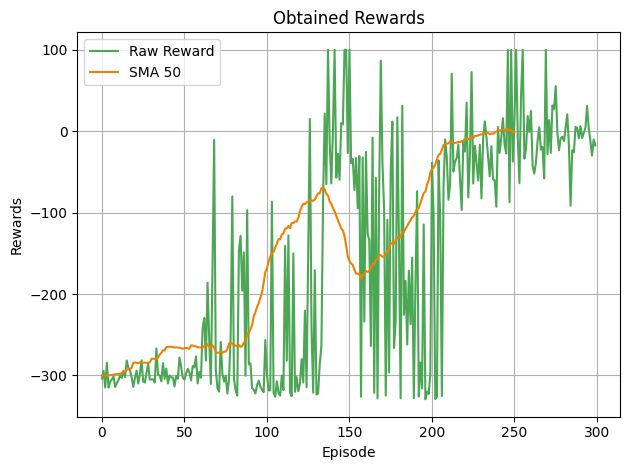

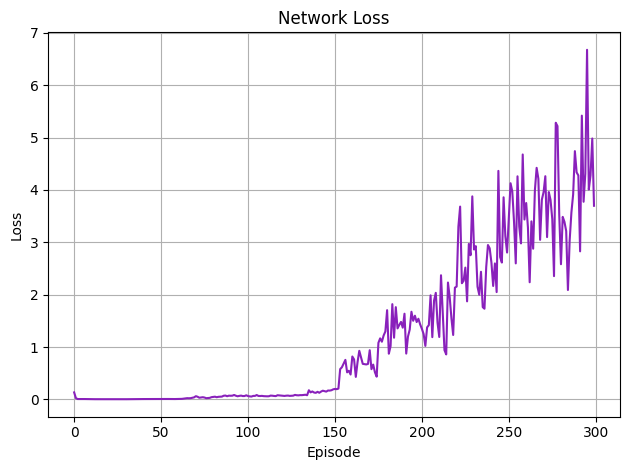


~~~~~~Interval Save: Model saved.

Episode: 300, Total Steps: 119854, Ep Step: 226, Raw Reward: -17.48, Epsilon: 0.41
Episode: 301, Total Steps: 120068, Ep Step: 214, Raw Reward: -13.98, Epsilon: 0.40
Episode: 302, Total Steps: 120296, Ep Step: 228, Raw Reward: -9.18, Epsilon: 0.40
Episode: 303, Total Steps: 120612, Ep Step: 316, Raw Reward: -88.83, Epsilon: 0.40
Episode: 304, Total Steps: 120834, Ep Step: 222, Raw Reward: -7.52, Epsilon: 0.40
Episode: 305, Total Steps: 121043, Ep Step: 209, Raw Reward: 14.46, Epsilon: 0.40
Episode: 306, Total Steps: 121250, Ep Step: 207, Raw Reward: -34.45, Epsilon: 0.40
Episode: 307, Total Steps: 121520, Ep Step: 270, Raw Reward: 118.12, Epsilon: 0.40
Episode: 308, Total Steps: 121723, Ep Step: 203, Raw Reward: -11.56, Epsilon: 0.40
Episode: 309, Total Steps: 122223, Ep Step: 500, Raw Reward: -54.54, Epsilon: 0.39
Episode: 310, Total Steps: 122723, Ep Step: 500, Raw Reward: -334.45, Epsilon: 0.39
Episode: 311, Total Steps: 123223, Ep Step: 500, Raw 

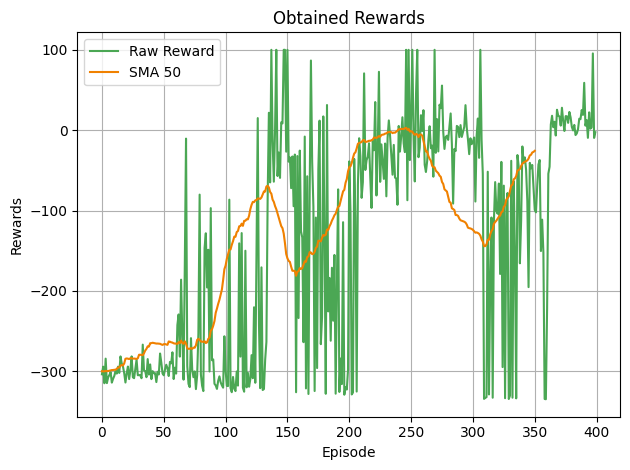

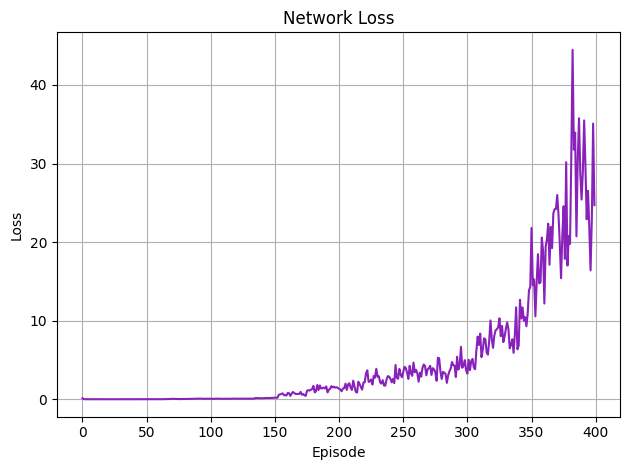


~~~~~~Interval Save: Model saved.

Episode: 400, Total Steps: 147831, Ep Step: 160, Raw Reward: -2.56, Epsilon: 0.30
Episode: 401, Total Steps: 148030, Ep Step: 199, Raw Reward: 7.57, Epsilon: 0.30
Episode: 402, Total Steps: 148186, Ep Step: 156, Raw Reward: 22.19, Epsilon: 0.30
Episode: 403, Total Steps: 148340, Ep Step: 154, Raw Reward: -1.59, Epsilon: 0.30
Episode: 404, Total Steps: 148505, Ep Step: 165, Raw Reward: 5.27, Epsilon: 0.30
Episode: 405, Total Steps: 148670, Ep Step: 165, Raw Reward: 32.72, Epsilon: 0.30
Episode: 406, Total Steps: 148832, Ep Step: 162, Raw Reward: 3.97, Epsilon: 0.29
Episode: 407, Total Steps: 148994, Ep Step: 162, Raw Reward: 4.84, Epsilon: 0.29
Episode: 408, Total Steps: 149158, Ep Step: 164, Raw Reward: 33.43, Epsilon: 0.29
Episode: 409, Total Steps: 149324, Ep Step: 166, Raw Reward: -2.98, Epsilon: 0.29
Episode: 410, Total Steps: 149492, Ep Step: 168, Raw Reward: 1.61, Epsilon: 0.29
Episode: 411, Total Steps: 149660, Ep Step: 168, Raw Reward: -3.00,

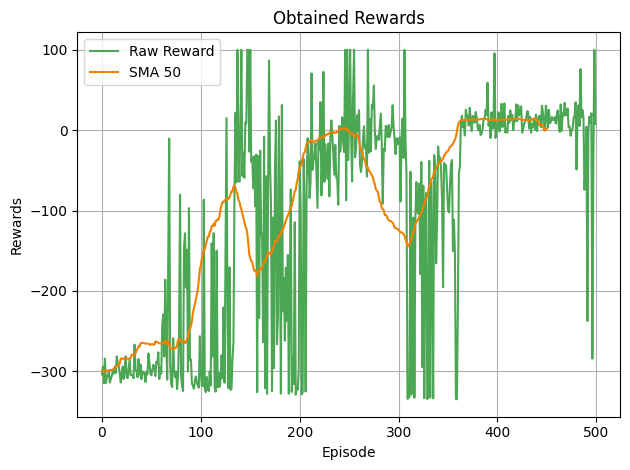

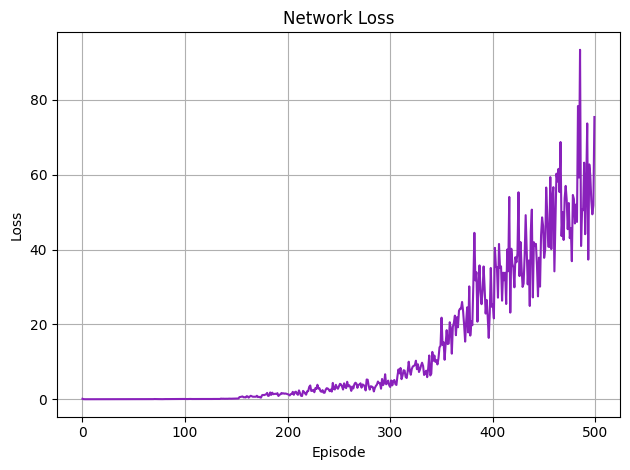


~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 165640, Ep Step: 170, Raw Reward: 7.77, Epsilon: 0.22
Episode: 501, Total Steps: 165808, Ep Step: 168, Raw Reward: 5.30, Epsilon: 0.22
Episode: 502, Total Steps: 165985, Ep Step: 177, Raw Reward: 29.82, Epsilon: 0.22
Episode: 503, Total Steps: 166379, Ep Step: 394, Raw Reward: -105.19, Epsilon: 0.22
Episode: 504, Total Steps: 166622, Ep Step: 243, Raw Reward: -17.67, Epsilon: 0.22
Episode: 505, Total Steps: 166790, Ep Step: 168, Raw Reward: 16.82, Epsilon: 0.22
Episode: 506, Total Steps: 167060, Ep Step: 270, Raw Reward: 49.59, Epsilon: 0.22
Episode: 507, Total Steps: 167242, Ep Step: 182, Raw Reward: 11.13, Epsilon: 0.22
Episode: 508, Total Steps: 167411, Ep Step: 169, Raw Reward: -2.51, Epsilon: 0.22
Episode: 509, Total Steps: 167584, Ep Step: 173, Raw Reward: 10.29, Epsilon: 0.22
Episode: 510, Total Steps: 167757, Ep Step: 173, Raw Reward: 10.62, Epsilon: 0.22
Episode: 511, Total Steps: 167962, Ep Step: 205, Raw Reward: 

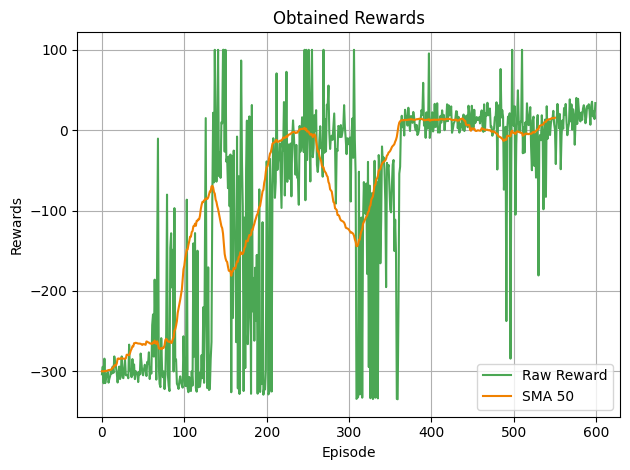

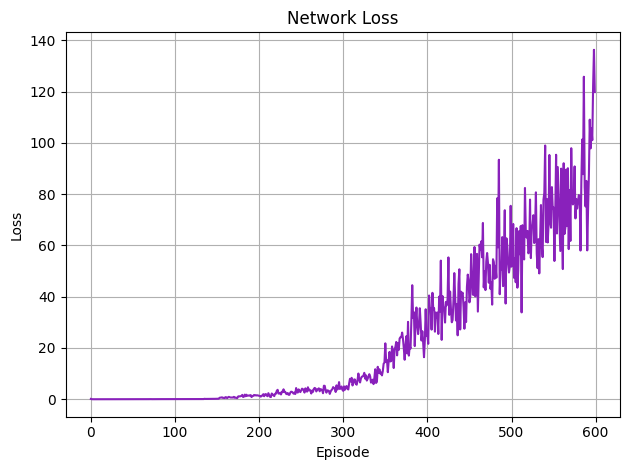


~~~~~~Interval Save: Model saved.

Episode: 600, Total Steps: 184854, Ep Step: 180, Raw Reward: 33.70, Epsilon: 0.16
Episode: 601, Total Steps: 185023, Ep Step: 169, Raw Reward: 19.55, Epsilon: 0.16
Episode: 602, Total Steps: 185188, Ep Step: 165, Raw Reward: 32.82, Epsilon: 0.16
Episode: 603, Total Steps: 185349, Ep Step: 161, Raw Reward: 24.87, Epsilon: 0.16
Episode: 604, Total Steps: 185517, Ep Step: 168, Raw Reward: 35.45, Epsilon: 0.16
Episode: 605, Total Steps: 185686, Ep Step: 169, Raw Reward: 31.48, Epsilon: 0.16
Episode: 606, Total Steps: 185857, Ep Step: 171, Raw Reward: 28.79, Epsilon: 0.16
Episode: 607, Total Steps: 186027, Ep Step: 170, Raw Reward: 15.18, Epsilon: 0.16
Episode: 608, Total Steps: 186194, Ep Step: 167, Raw Reward: 15.10, Epsilon: 0.16
Episode: 609, Total Steps: 186359, Ep Step: 165, Raw Reward: 23.06, Epsilon: 0.16
Episode: 610, Total Steps: 186532, Ep Step: 173, Raw Reward: 17.91, Epsilon: 0.16
Episode: 611, Total Steps: 186698, Ep Step: 166, Raw Reward: 3

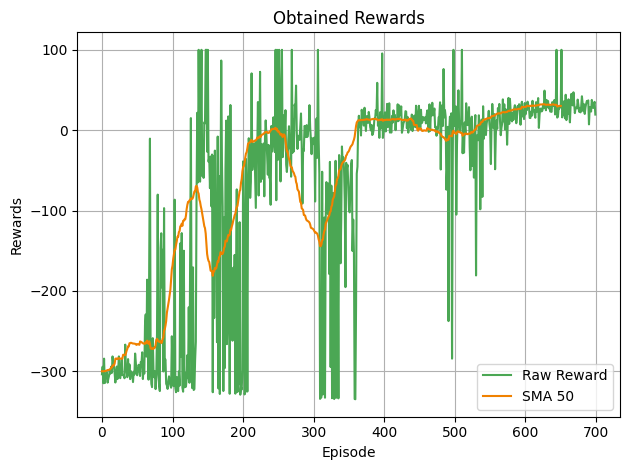

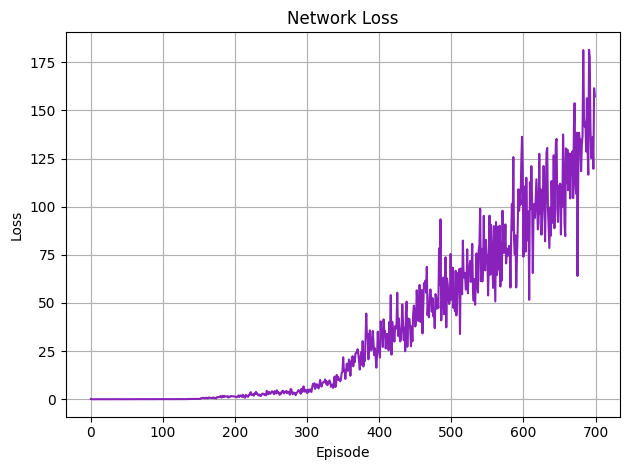


~~~~~~Interval Save: Model saved.

Episode: 700, Total Steps: 201641, Ep Step: 162, Raw Reward: 19.39, Epsilon: 0.12
Episode: 701, Total Steps: 201798, Ep Step: 157, Raw Reward: 16.16, Epsilon: 0.12
Episode: 702, Total Steps: 201964, Ep Step: 166, Raw Reward: 35.53, Epsilon: 0.12
Episode: 703, Total Steps: 202126, Ep Step: 162, Raw Reward: 23.33, Epsilon: 0.12
Episode: 704, Total Steps: 202297, Ep Step: 171, Raw Reward: 41.63, Epsilon: 0.12
Episode: 705, Total Steps: 202459, Ep Step: 162, Raw Reward: 34.62, Epsilon: 0.12
Episode: 706, Total Steps: 202613, Ep Step: 154, Raw Reward: 7.74, Epsilon: 0.12
Episode: 707, Total Steps: 202775, Ep Step: 162, Raw Reward: 13.63, Epsilon: 0.12
Episode: 708, Total Steps: 202943, Ep Step: 168, Raw Reward: 31.20, Epsilon: 0.12
Episode: 709, Total Steps: 203114, Ep Step: 171, Raw Reward: 38.58, Epsilon: 0.12
Episode: 710, Total Steps: 203279, Ep Step: 165, Raw Reward: 35.09, Epsilon: 0.12
Episode: 711, Total Steps: 203442, Ep Step: 163, Raw Reward: 35

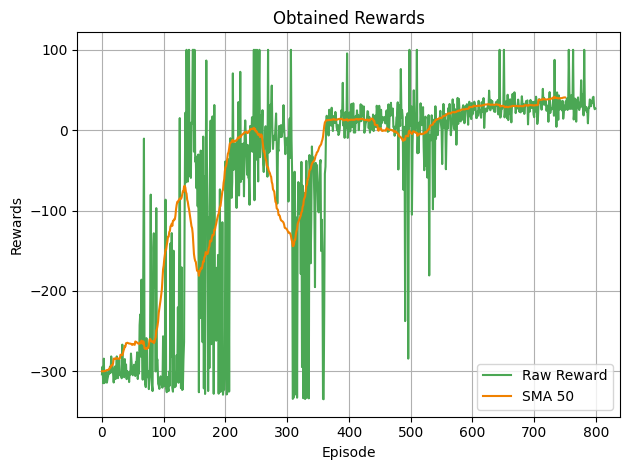

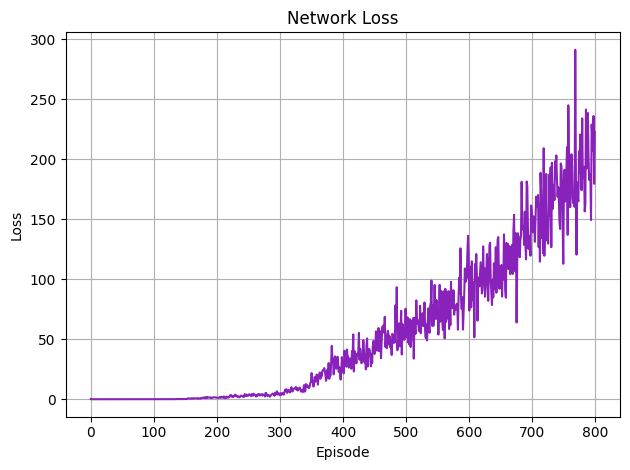


~~~~~~Interval Save: Model saved.

Episode: 800, Total Steps: 218415, Ep Step: 165, Raw Reward: 26.75, Epsilon: 0.09
Episode: 801, Total Steps: 218592, Ep Step: 177, Raw Reward: 43.56, Epsilon: 0.09
Episode: 802, Total Steps: 218774, Ep Step: 182, Raw Reward: 31.47, Epsilon: 0.09
Episode: 803, Total Steps: 218947, Ep Step: 173, Raw Reward: 42.17, Epsilon: 0.09
Episode: 804, Total Steps: 219120, Ep Step: 173, Raw Reward: 36.05, Epsilon: 0.09
Episode: 805, Total Steps: 219301, Ep Step: 181, Raw Reward: 37.10, Epsilon: 0.09
Episode: 806, Total Steps: 219466, Ep Step: 165, Raw Reward: 32.70, Epsilon: 0.09
Episode: 807, Total Steps: 219626, Ep Step: 160, Raw Reward: 17.72, Epsilon: 0.09
Episode: 808, Total Steps: 219798, Ep Step: 172, Raw Reward: 37.22, Epsilon: 0.09
Episode: 809, Total Steps: 219971, Ep Step: 173, Raw Reward: 35.95, Epsilon: 0.09
Episode: 810, Total Steps: 220145, Ep Step: 174, Raw Reward: 29.17, Epsilon: 0.09
Episode: 811, Total Steps: 220330, Ep Step: 185, Raw Reward: 4

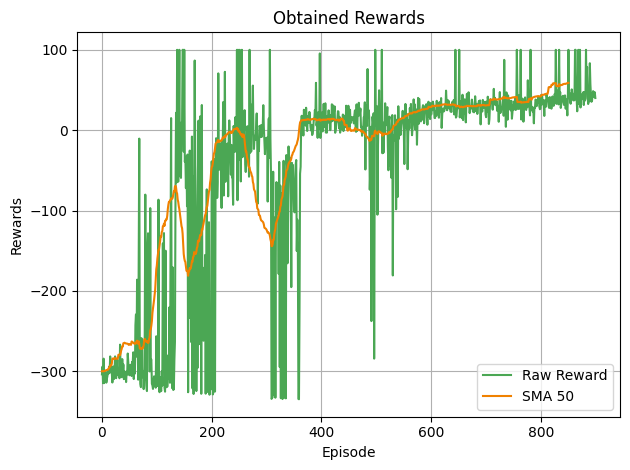

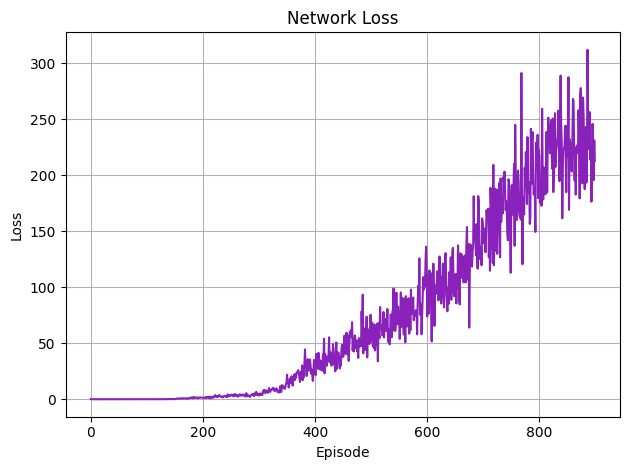


~~~~~~Interval Save: Model saved.

Episode: 900, Total Steps: 235509, Ep Step: 171, Raw Reward: 39.98, Epsilon: 0.07
Episode: 901, Total Steps: 235642, Ep Step: 133, Raw Reward: 288.19, Epsilon: 0.07
Episode: 902, Total Steps: 235813, Ep Step: 171, Raw Reward: 39.40, Epsilon: 0.07
Episode: 903, Total Steps: 235943, Ep Step: 130, Raw Reward: 253.58, Epsilon: 0.07
Episode: 904, Total Steps: 236116, Ep Step: 173, Raw Reward: 39.53, Epsilon: 0.07
Episode: 905, Total Steps: 236228, Ep Step: 112, Raw Reward: 161.96, Epsilon: 0.07
Episode: 906, Total Steps: 236395, Ep Step: 167, Raw Reward: 30.87, Epsilon: 0.07
Episode: 907, Total Steps: 236588, Ep Step: 193, Raw Reward: 171.56, Epsilon: 0.07
Episode: 908, Total Steps: 236757, Ep Step: 169, Raw Reward: 38.53, Epsilon: 0.07
Episode: 909, Total Steps: 236919, Ep Step: 162, Raw Reward: 33.65, Epsilon: 0.07
Episode: 910, Total Steps: 237077, Ep Step: 158, Raw Reward: 29.89, Epsilon: 0.06
Episode: 911, Total Steps: 237236, Ep Step: 159, Raw Rewar

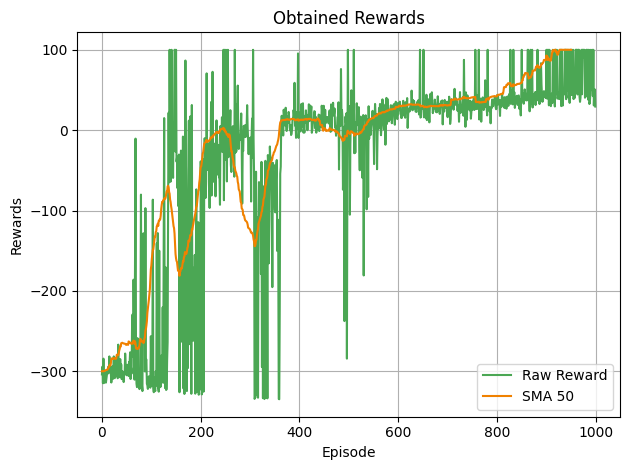

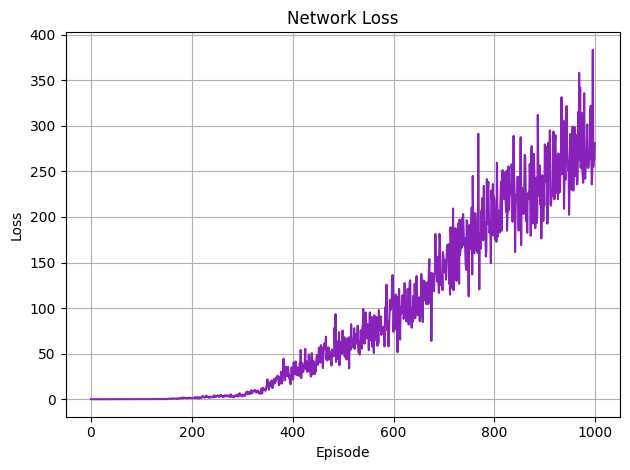

In [10]:
train_mode = True
render = not train_mode
RL_hyperparams = {
    "train_mode"            : train_mode,
    "RL_load_path"          : './final_weights' + '_' + '1000' + '.pth',
    "save_path"             : './final_weights',
    "save_interval"         : 100,

    "clip_grad_norm"        : 5,
    "learning_rate"         : 75e-5,
    "discount_factor"       : 0.96,
    "batch_size"            : 64,
    "update_frequency"      : 20,
    "max_episodes"          : 1000           if train_mode else 2,
    "max_steps"             : 500,
    "render"                : render,

    "epsilon_max"           : 0.999         if train_mode else -1,
    "epsilon_min"           : 0.01,
    "epsilon_decay"         : 0.997,

    "memory_capacity"       : 125_000        if train_mode else 0,

    "render_fps"            : 60,
    }


# Run
DRL = Model_TrainTest(RL_hyperparams) # Define the instance
# Train
if train_mode:
    DRL.train()
else:
    # Test
    # history,frames = DRL.test(max_episodes = RL_hyperparams['max_episodes'])
    history,frames,steps,rewards,failed = DRL.test(max_episodes =50)